# Phase 1: Data Import and Cleaning

**Purpose**:  
- Import the CSV file containing UCSD course grade distributions.  
- Parse each row's letter-grade distribution, filtering out non-traditional grades and meta info.  
- Compute the average GPA when possible, and classify rows into "computable" vs. "noncomputable" categories.  
- Summarize the final distribution for further analysis in subsequent phases.

**Key Points**:  
- Non-traditional letters (P, NP, W, etc.) do NOT affect GPA.  
- Rows stating "Grade Distribution is not available..." are considered noncomputable (no valid data).  
- We use Pandas to handle missing values.  
- We fix the issue where `None` in Python becomes `NaN` in Pandas, ensuring `NaN` is treated as "noncomputable."  

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# For inline plots in Jupyter
%matplotlib inline

In [4]:
# Define the path to the CSV file
data_file = os.path.join("..", "data", "Crowd-sourced grade distributions - Sheet1.csv")

# Read the CSV file into a DataFrame
df = pd.read_csv(data_file)

# Quick preview
print("Preview of the dataset:")
display(df.head())

# Basic info
print("\nDataFrame info:")
df.info()

print("\nMissing values per column:")
display(df.isnull().sum())

Preview of the dataset:


,Submission time,User ID,Term,Course,Professor,Grade distribution,Recommend professor?
0,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 120,"Voelker, Geoffrey M.","A+:11, A:41, A-:25, B+:41, B:28, B-:16, C+:12,...",NaN
1,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 132A,"Vianu, Victor Dan","A+:4, A:23, A-:19, B+:40, B:15, B-:27, C+:15, ...",NaN
2,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 141L,"Eldon, John","A+:1, A:28, A-:4, B+:2, B:0, B-:3, C+:0, C:3, ...",NaN
3,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 167,"Li, Tzumao","A+:102, A:22, A-:11, B+:5, B:7, B-:6, C+:2, C:...",NaN
4,2023-12-23T05:50:18.840Z,b144031aa5f07b5677aa3431b98f674d,Fall Qtr 2023,CSE 230,"Jhala, Ranjit","A+:29, A:42, A-:26, B+:16, B:7, B-:1, C+:0, C:...",NaN



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9454 entries, 0 to 9453
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Submission time       9454 non-null   object 
 1   User ID               9454 non-null   object 
 2   Term                  9454 non-null   object 
 3   Course                9454 non-null   object 
 4   Professor             9454 non-null   object 
 5   Grade distribution    9454 non-null   object 
 6   Recommend professor?  0 non-null      float64
dtypes: float64(1), object(6)
memory usage: 517.1+ KB

Missing values per column:


Submission time            0
User ID                    0
Term                       0
Course                     0
Professor                  0
Grade distribution         0
Recommend professor?    9454
dtype: int64

### Processing & Cleaning Strategy

1. **Letter-Grade Parsing**  
   - Each row has a `Grade distribution` string, e.g. `"A+:12, A-:3, B:10, W:1, ..."`.
   - We split by commas, then by ":" to map each grade letter to its count.

2. **Standard vs. Non-Traditional**  
   - We define a `grade_points_map_lower` for standard letters (`"a", "b", "c", "d", "f"` and +/-).  
   - We define a `skip_letters` set for meta info or non-traditional letters (`p, np, w, i, ip, s, u, class gpa, total students, blank`).  
   - If a row indicates `"Grade Distribution is not available..."`, we consider that row entirely noncomputable.

3. **Compute Average GPA**  
   - Sum of (grade_count × letter_GPA_value) / total_students for that row.
   - If `total_students == 0`, return `None`.

4. **Handling Pandas NaN**  
   - When `None` is stored in a DataFrame cell, it becomes `NaN`. We use `pd.notna()` to check if the computed GPA is a valid number. Otherwise, it’s "noncomputable."

5. **Classification**  
   - We create a `gpa_status` column: `"computable"` if `enhanced_calculated_gpa` is a valid float, `"noncomputable"` if it’s `NaN`.

6. **Outcome**  
   - We'll see how many rows are computable vs. noncomputable, then show a distribution histogram of `enhanced_calculated_gpa`.

In [6]:
# Define our maps in lowercase
grade_points_map_lower = {
    "a+": 4.0, "a": 4.0, "a-": 3.7,
    "b+": 3.3, "b": 3.0, "b-": 2.7,
    "c+": 2.3, "c": 2.0, "c-": 1.7,
    "d+": 1.3, "d": 1.0, "d-": 0.7,
    "f": 0.0
}

# Non-traditional or meta info to skip
skip_letters = {
    "class gpa", "total students", "blank",
    "p", "np", "s", "u", "w", "i", "ip"
}

def parse_grade_distribution_enhanced(dist_str):
    dist_str_lower = dist_str.lower()
    # If distribution info is not available, return empty dict
    if "not available" in dist_str_lower:
        return {}

    grades = {}
    parts = dist_str.split(',')
    for part in parts:
        part = part.strip()
        if not part:
            continue
        letter_count = part.split(':')
        if len(letter_count) == 2:
            letter_raw, count_str = letter_count
            letter_lower = letter_raw.strip().lower()

            # Skip meta info / non-traditional
            if letter_lower in skip_letters:
                continue

            # Convert the count to int
            try:
                count = int(count_str.strip())
            except ValueError:
                count = 0

            # Keep only standard letters
            if letter_lower in grade_points_map_lower:
                grades[letter_lower] = grades.get(letter_lower, 0) + count
    return grades

def compute_average_gpa_enhanced(grades_dict):
    total_students = 0
    total_points = 0.0
    for letter_lower, cnt in grades_dict.items():
        if letter_lower in grade_points_map_lower:
            total_students += cnt
            total_points += cnt * grade_points_map_lower[letter_lower]
    if total_students == 0:
        return None
    return total_points / total_students

# Apply final parse function
df["enhanced_grade_dict"] = df["Grade distribution"].astype(str).apply(parse_grade_distribution_enhanced)
df["enhanced_calculated_gpa"] = df["enhanced_grade_dict"].apply(compute_average_gpa_enhanced)

Total rows: 9454
Computable rows: 8664
Noncomputable rows: 790
Percentage of computable rows: 91.64%


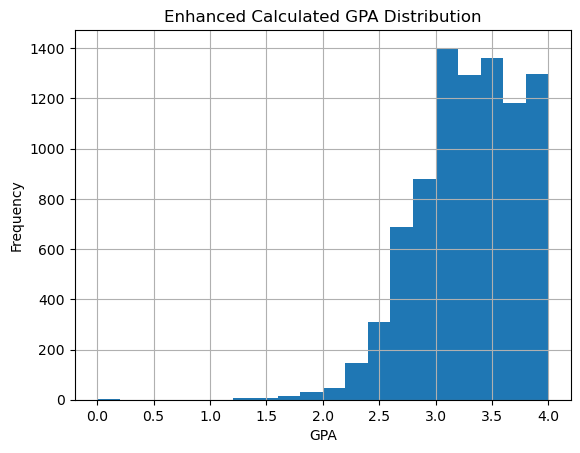

In [7]:
# Use pd.notna() to handle NaN
def classify_gpa_status(gpa_value):
    return "computable" if pd.notna(gpa_value) else "noncomputable"

df["gpa_status"] = df["enhanced_calculated_gpa"].apply(classify_gpa_status)

# Summaries
total_rows = len(df)
computable_rows = (df["gpa_status"] == "computable").sum()
noncomputable_rows = (df["gpa_status"] == "noncomputable").sum()

print(f"Total rows: {total_rows}")
print(f"Computable rows: {computable_rows}")
print(f"Noncomputable rows: {noncomputable_rows}")
print(f"Percentage of computable rows: {computable_rows / total_rows * 100:.2f}%")

# Quick histogram for computed GPA
df_computable = df[df["gpa_status"] == "computable"]
if not df_computable.empty:
    df_computable["enhanced_calculated_gpa"].hist(bins=20)
    plt.title("Enhanced Calculated GPA Distribution")
    plt.xlabel("GPA")
    plt.ylabel("Frequency")
    plt.show()

### Conclusion

- We've successfully parsed each row's grade distribution to extract standard letter counts and computed an average GPA where possible.  
- Rows with only non-traditional letters (or where distribution was "not available") are marked as `"noncomputable"`.  
- This final DataFrame now has columns:
  - **`enhanced_grade_dict`**: A dict of standard letters and their counts.  
  - **`enhanced_calculated_gpa`**: A float or NaN, depending on whether enough data was available.  
  - **`gpa_status`**: `"computable"` or `"noncomputable"`.  

These outputs form the foundation for our further analyses (e.g., comparing courses/professors, analyzing GPA trends, or combining with Drop rates). This concludes Phase 1 of our UCSD Course Evaluate project.